In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from transformers import ViTForImageClassification, ViTFeatureExtractor
from torch import nn, optim
import os


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip uninstall -y transformers huggingface-hub
!rm -rf /usr/local/lib/python3.*/dist-packages/transformers*
!rm -rf /usr/local/lib/python3.*/dist-packages/huggingface_hub*
!pip install --no-cache-dir transformers==4.37.2


Found existing installation: transformers 4.37.2
Uninstalling transformers-4.37.2:
  Successfully uninstalled transformers-4.37.2
Found existing installation: huggingface-hub 0.33.2
Uninstalling huggingface-hub-0.33.2:
  Successfully uninstalled huggingface-hub-0.33.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 140.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.4/515.4 kB 120.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 4.1.0 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.37.2 which is incompatible.


In [ ]:
import zipfile
import os

# Replace this with your actual zip file path in Drive
zip_path = '/content/drive/MyDrive/autism_spectrum.zip'
extract_path = '/content/AutismDataset'

# Extract
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(" Dataset extracted!")


 Dataset extracted!


In [ ]:
import os

for file in os.listdir(extract_path):
    print(file)


Autism Screening.csv


In [ ]:
import pandas as pd

# Load the CSV
df = pd.read_csv('/content/AutismDataset/Autism Screening.csv')

# Display basic info
print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
df.head()


Shape: (704, 21)

Columns: ['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'age', 'gender', 'ethnicity', 'jundice', 'austim', 'contry_of_res', 'used_app_before', 'result', 'age_desc', 'relation', 'Class/ASD']


,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,...,gender,ethnicity,jundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD
0,1,1,1,1,0,0,1,1,0,0,...,f,White-European,no,no,'United States',no,6,'18 and more',Self,NO
1,1,1,0,1,0,0,0,1,0,1,...,m,Latino,no,yes,Brazil,no,5,'18 and more',Self,NO
2,1,1,0,1,1,0,1,1,1,1,...,m,Latino,yes,yes,Spain,no,8,'18 and more',Parent,YES
3,1,1,0,1,0,0,1,1,0,1,...,f,White-European,no,yes,'United States',no,6,'18 and more',Self,NO
4,1,0,0,0,0,0,0,1,0,0,...,f,?,no,no,Egypt,no,2,'18 and more',?,NO


In [ ]:
# Check for missing values
print("\nMissing Values:\n", df.isnull().sum())

# Check class distribution
print("\nClass Distribution:\n", df['Class/ASD'].value_counts())



Missing Values:
 A1_Score           0
A2_Score           0
A3_Score           0
A4_Score           0
A5_Score           0
A6_Score           0
A7_Score           0
A8_Score           0
A9_Score           0
A10_Score          0
age                0
gender             0
ethnicity          0
jundice            0
austim             0
contry_of_res      0
used_app_before    0
result             0
age_desc           0
relation           0
Class/ASD          0
dtype: int64

Class Distribution:
 Class/ASD
NO     515
YES    189
Name: count, dtype: int64


In [ ]:
# Map target column to binary
df['label'] = df['Class/ASD'].map({'NO': 0, 'YES': 1})

# Select only the 10 screening scores
score_cols = [f'A{i}_Score' for i in range(1, 11)]
X_scores = df[score_cols]
y = df['label']

print("\nSample Features:\n", X_scores.head())
print("\nLabels:\n", y.value_counts())



Sample Features:
    A1_Score  A2_Score  A3_Score  A4_Score  A5_Score  A6_Score  A7_Score  \
0         1         1         1         1         0         0         1   
1         1         1         0         1         0         0         0   
2         1         1         0         1         1         0         1   
3         1         1         0         1         0         0         1   
4         1         0         0         0         0         0         0   

   A8_Score  A9_Score  A10_Score  
0         1         0          0  
1         1         0          1  
2         1         1          1  
3         1         0          1  
4         1         0          0  

Labels:
 label
0    515
1    189
Name: count, dtype: int64


In [ ]:
# Generate Images from Screening Scores
import os

# Create folders to save images
base_dir = "/content/vit_data"
train_img_dir = os.path.join(base_dir, "images")
label_csv_path = os.path.join(base_dir, "labels.csv")

os.makedirs(train_img_dir, exist_ok=True)
print(" Image directory created:", train_img_dir)


 Image directory created: /content/vit_data/images


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import uuid

image_paths = []
labels = []

for idx, row in X_scores.iterrows():
    label = y.iloc[idx]
    scores = row.values.astype(int)

    # Generate a unique filename
    file_id = str(uuid.uuid4())
    img_path = os.path.join(train_img_dir, f"{file_id}.png")

    # Plot bar chart
    plt.figure(figsize=(2, 2))  # small size for ViT
    plt.bar(np.arange(1, 11), scores, color='skyblue')
    plt.xticks([])  # remove x-axis ticks
    plt.yticks([])
    plt.tight_layout()
    plt.axis('off')  # turn off axes
    plt.savefig(img_path, dpi=100)
    plt.close()

    image_paths.append(img_path)
    labels.append(label)

print(f" {len(image_paths)} images generated.")


 704 images generated.


In [ ]:
import pandas as pd

# Create DataFrame with image paths and labels
label_df = pd.DataFrame({
    "image_path": image_paths,
    "label": labels
})

# Save to CSV
label_df.to_csv(label_csv_path, index=False)
print(f" Labels saved to: {label_csv_path}")


 Labels saved to: /content/vit_data/labels.csv


In [ ]:
import os

img_dir = '/content/vit_data/images'
label_csv_path = '/content/vit_data/labels.csv'

print("Total images:", len(os.listdir(img_dir)))


Total images: 1408


In [ ]:
#deine dataset class(pytorch)
from torch.utils.data import Dataset
from PIL import Image
import pandas as pd

class AutismImageDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]['image_path']
        label = self.data.iloc[idx]['label']
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label


In [ ]:
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torch.utils.data import DataLoader

# Split CSV
df = pd.read_csv(label_csv_path)
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

# Save them
train_df.to_csv("/content/vit_data/train.csv", index=False)
test_df.to_csv("/content/vit_data/test.csv", index=False)

# Image transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Datasets
train_dataset = AutismImageDataset("/content/vit_data/train.csv", transform=transform)
test_dataset = AutismImageDataset("/content/vit_data/test.csv", transform=transform)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [ ]:
from transformers import ViTForImageClassification, ViTFeatureExtractor

feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')

model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224',
    num_labels=2,
    ignore_mismatched_sizes=True
)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transforme

In [ ]:
import torch
from torch import nn, optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images).logits
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()

    accuracy = correct / len(train_dataset)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss:.4f}, Train Accuracy: {accuracy:.4f}")


Epoch 1/10, Loss: 3.4911, Train Accuracy: 0.9627
Epoch 2/10, Loss: 1.5327, Train Accuracy: 0.9822
Epoch 3/10, Loss: 2.6126, Train Accuracy: 0.9627
Epoch 4/10, Loss: 1.2571, Train Accuracy: 0.9911
Epoch 5/10, Loss: 0.0195, Train Accuracy: 1.0000
Epoch 6/10, Loss: 2.7805, Train Accuracy: 0.9769
Epoch 7/10, Loss: 3.6211, Train Accuracy: 0.9627
Epoch 8/10, Loss: 2.9366, Train Accuracy: 0.9645
Epoch 9/10, Loss: 1.4055, Train Accuracy: 0.9805
Epoch 10/10, Loss: 0.8218, Train Accuracy: 0.9893


In [ ]:
model.eval()
correct = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images).logits
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()

test_acc = correct / len(test_dataset)
print(f"\n Test Accuracy: {test_acc:.4f}")



 Test Accuracy: 0.9929


In [ ]:
# Save the trained model
model_save_path = "/content/drive/MyDrive/vit_asd_model.pth"
torch.save(model.state_dict(), model_save_path)

print(f"✅ Model saved at: {model_save_path}")


✅ Model saved at: /content/drive/MyDrive/vit_asd_model.pth


In [ ]:
from transformers import ViTFeatureExtractor
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")
feature_extractor.save_pretrained("/content/drive/MyDrive/vit_feature_extractor")


/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


['/content/drive/MyDrive/vit_feature_extractor/preprocessor_config.json']

In [ ]:
from google.colab import files
files.download("/content/drive/MyDrive/vit_asd_model.pth")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch  # unpack tuple
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        preds = torch.argmax(outputs.logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

y_true = np.array(all_labels)
y_pred = np.array(all_preds)


In [ ]:
from sklearn.metrics import classification_report

print(" Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=["Non-ASD", "ASD"]))


 Classification Report:

              precision    recall  f1-score   support

     Non-ASD       1.00      0.99      1.00       103
         ASD       0.97      1.00      0.99        38

    accuracy                           0.99       141
   macro avg       0.99      1.00      0.99       141
weighted avg       0.99      0.99      0.99       141



In [ ]:
from sklearn.metrics import cohen_kappa_score

kappa = cohen_kappa_score(y_true, y_pred)
print(f" Cohen's Kappa Score: {kappa:.4f}")


 Cohen's Kappa Score: 0.9821


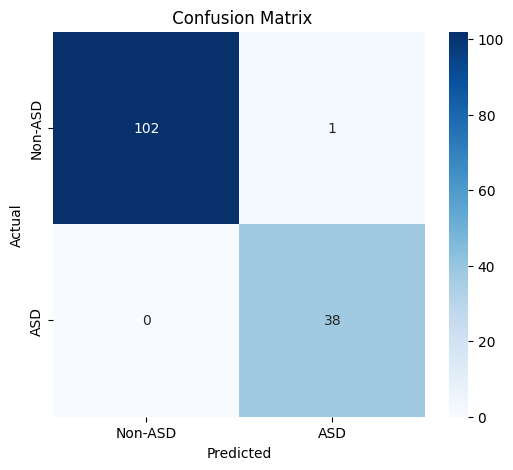

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Non-ASD", "ASD"],
            yticklabels=["Non-ASD", "ASD"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(" Confusion Matrix")
plt.show()


In [ ]:
model.eval()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for batch in test_loader:
        pixel_values, labels = batch  # ✅ Correct unpacking
        pixel_values = pixel_values.to(device)
        labels = labels.to(device)

        outputs = model(pixel_values)
        probs = torch.softmax(outputs.logits, dim=1)[:, 1]  # probability of class 1 (ASD)
        preds = torch.argmax(outputs.logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

y_true = np.array(all_labels)
y_pred = np.array(all_preds)
y_probs = np.array(all_probs)  # needed for AUC


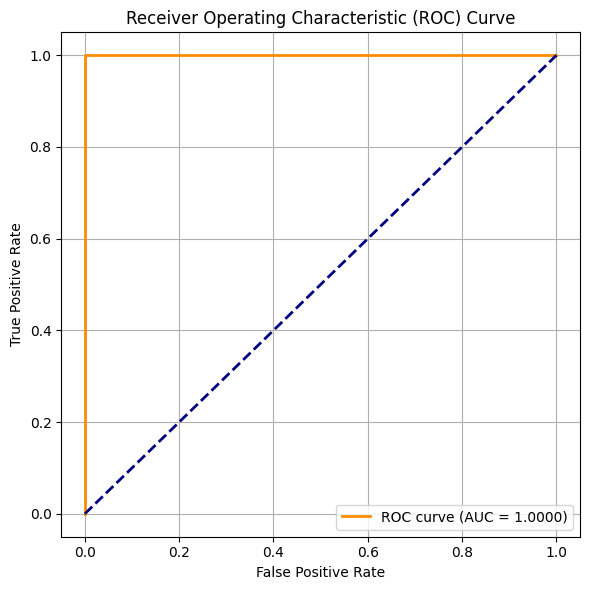

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_true, y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
print(f"AUC Score: {roc_auc:.4f}")


AUC Score: 1.0000


In [ ]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    cohen_kappa_score, confusion_matrix, roc_curve, auc
)
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Basic Classification Metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
kappa = cohen_kappa_score(y_true, y_pred)

print(f"✅ Accuracy:  {accuracy:.4f}")
print(f"✅ Precision: {precision:.4f}")
print(f"✅ Recall:    {recall:.4f}")
print(f"✅ F1 Score:  {f1:.4f}")
print(f"✅ Kappa:     {kappa:.4f}")


✅ Accuracy:  0.9929
✅ Precision: 0.9744
✅ Recall:    1.0000
✅ F1 Score:  0.9870
✅ Kappa:     0.9821


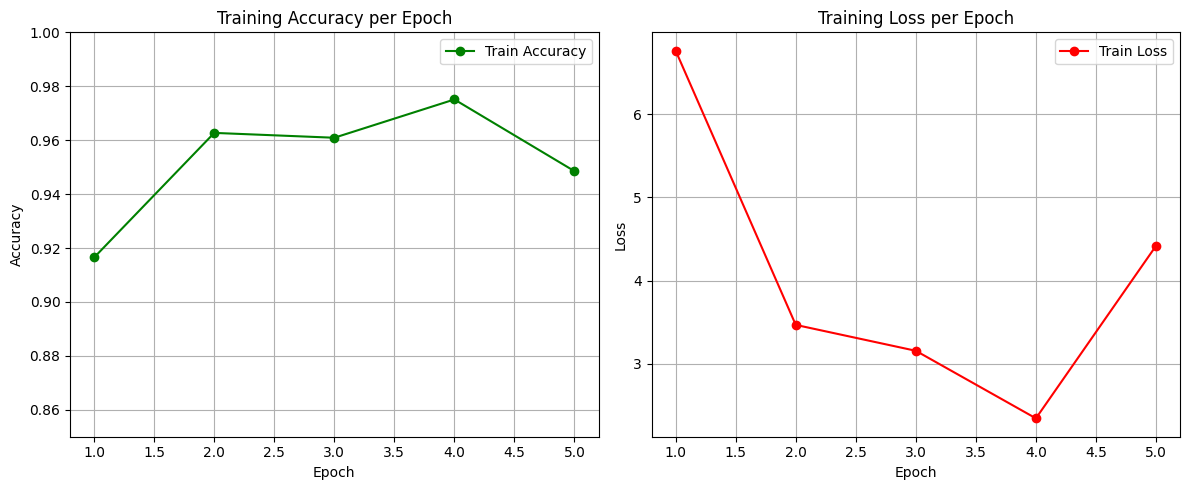

In [ ]:
import matplotlib.pyplot as plt

# Extracted from your training logs
epochs = [1, 2, 3, 4, 5]
train_losses = [6.7643, 3.4670, 3.1555, 2.3432, 4.4171]
train_accuracies = [0.9165, 0.9627, 0.9609, 0.9751, 0.9485]

# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracies, marker='o', label='Train Accuracy', color='green')
plt.title('Training Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0.85, 1.0)
plt.grid(True)
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, marker='o', label='Train Loss', color='red')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import uuid

# Directory to save test images
test_img_dir = "/content/test_images"
os.makedirs(test_img_dir, exist_ok=True)

def generate_test_image(scores, name):
    plt.figure(figsize=(2, 2))
    plt.bar(np.arange(1, 11), scores, color='skyblue')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.axis('off')
    img_path = os.path.join(test_img_dir, f"{name}_{str(uuid.uuid4())[:8]}.png")
    plt.savefig(img_path, dpi=100)
    plt.close()
    return img_path

# Generate 3 test images
asdl_img = generate_test_image([1]*10, "ASD")
non_asdl_img = generate_test_image([0]*10, "NonASD")
random_img = generate_test_image(np.random.randint(0, 2, 10), "Random")

print("✅ Test images saved at:")
print("ASD Image:", asdl_img)
print("Non-ASD Image:", non_asdl_img)
print("Random Image:", random_img)


✅ Test images saved at:
ASD Image: /content/test_images/ASD_99429013.png
Non-ASD Image: /content/test_images/NonASD_c8b132a4.png
Random Image: /content/test_images/Random_59e694ab.png


In [ ]:
from google.colab import files

# Download all 3 test images
files.download(asdl_img)
files.download(non_asdl_img)
files.download(random_img)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


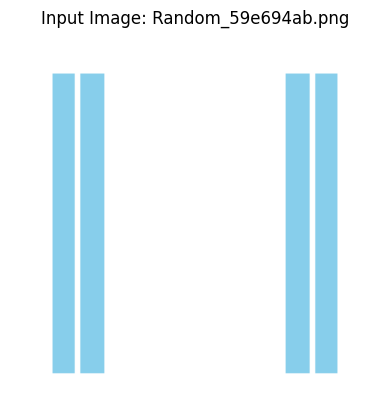

 **Prediction** for `Random_59e694ab.png`: Non-ASD
------------------------------------------------------------


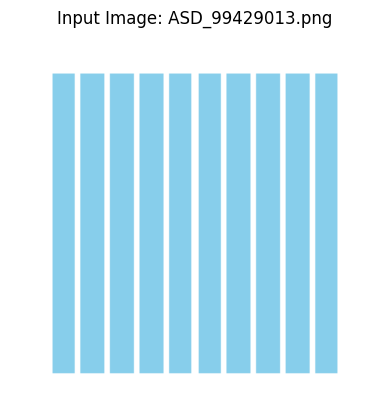

 **Prediction** for `ASD_99429013.png`: ASD
------------------------------------------------------------


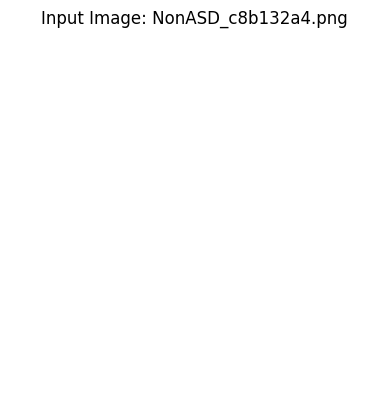

 **Prediction** for `NonASD_c8b132a4.png`: Non-ASD
------------------------------------------------------------


In [ ]:
from PIL import Image
from transformers import ViTFeatureExtractor
import torch
import matplotlib.pyplot as plt
import os

# Load the trained model (if not already loaded)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Re-load the feature extractor
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")

# Define your class names
class_names = ['Non-ASD', 'ASD']  # adjust if reversed

# Image paths (update if needed)
test_dir = "/content/test_images"
test_images = [os.path.join(test_dir, f) for f in os.listdir(test_dir) if f.endswith(".png")]

# Prediction and display
for img_path in test_images:
    # Load and show the image
    image = Image.open(img_path).convert("RGB")
    plt.imshow(image)
    plt.title(f"Input Image: {os.path.basename(img_path)}")
    plt.axis('off')
    plt.show()

    # Preprocess
    inputs = feature_extractor(images=image, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Predict
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_class = torch.argmax(logits, dim=1).item()

    print(f" **Prediction** for `{os.path.basename(img_path)}`: {class_names[predicted_class]}")
    print("-" * 60)
